# Integrator probing

Including the bar can sometimes cause orbits to not be reverse integratable. I will modify integrator.f90 to print the intermediate accelerations so that they can be checked 


In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bar_sensitivity_integration_timestep_and_time as bsitt

In [2]:
def backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar

    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    tstrippy.integrator.setbackwardorbit()
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.setdebugbarorientation()
    starttime = datetime.datetime.now()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    endtime=datetime.datetime.now()
    aBAR = tstrippy.integrator.abar.copy()
    aSG = tstrippy.integrator.asg.copy()
    barrtheta = tstrippy.integrator.bartheta.copy()
    backtimestamps = tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()
    orbit = [xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    accelerations = [aSG,aBAR]
    return orbit, accelerations, barrtheta, backtimestamps


In [3]:
def forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar
    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.setdebugbarorientation()
    starttime = datetime.datetime.now()
    xForward,yForward,zForward,vxForward,vyForward,vzForward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    aBAR = tstrippy.integrator.abar.copy()
    aSG = tstrippy.integrator.asg.copy()
    barrtheta = tstrippy.integrator.bartheta.copy()
    forwardtimestamps = tstrippy.integrator.timestamps.copy()
    endtime=datetime.datetime.now()
    tstrippy.integrator.deallocate()
    orbit = [xForward,yForward,zForward,vxForward,vyForward,vzForward]
    accelerations = [aSG,aBAR]
    return orbit, accelerations, barrtheta, forwardtimestamps


In [4]:
def backward_and_forward_orbit(integrationtime,timestep,staticgalaxy,initialkinematics,galacticbar):
    

    assert integrationtime > 0
    assert timestep > 0
    assert isinstance(integrationtime, (int, float))
    assert isinstance(timestep, (int, float))
    unitT, unitV, unitD, unitM, unitG, G = bsitt.loadunits()

    # convert to integration units
    Ntimestep=int(integrationtime/timestep)
    T,dt=integrationtime*u.yr,timestep*u.yr
    T,dt=T.to(unitT),dt.to(unitT)
    # make sure the current time is set to today for backward integration
    currenttime = 0*unitT
    integrationparameters = [currenttime,dt,Ntimestep]
    backorbit, backcaccel, backbartheta, backtimestamps = \
        backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward = backorbit
    # extract the final conditions for the forward integration
    xf,yf,zf,vxf,vyf,vzf = xBackward[0][-1],yBackward[0][-1],zBackward[0][-1],-vxBackward[0][-1],-vyBackward[0][-1],-vzBackward[0][-1]
    # set the initial time 
    currenttime = -T
    initialkinematics = [xf,yf,zf,vxf,vyf,vzf]
    integrationparameters = [currenttime,dt,Ntimestep]
    forwardorbit, forwardaccel, forwardbartheta, forwardtimestamps = \
        forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xForward,yForward,zForward,vxForward,vyForward,vzForward = forwardorbit
    backwardorbit = [xBackward[0],yBackward[0],zBackward[0],-vxBackward[0],-vyBackward[0],-vzBackward[0]]
    forwardorbit = [xForward[0],yForward[0],zForward[0],vxForward[0],vyForward[0],vzForward[0]]
    
    return backwardorbit, forwardorbit, backcaccel, forwardaccel, backbartheta, forwardbartheta, backtimestamps, forwardtimestamps

In [5]:
targetGC = "NGC5139"
# load units
unitT, unitV, unitD, unitM, unitG, G=bsitt.loadunits()
# Load the galaxy parameters
MWparams, MWrefframe = bsitt.loadGalaxy()
# Load the bar parameters
barparams = bsitt.barparams_ferrone2023()
# Load the bar movement
barpolycoeff = bsitt.bar_movement_ferrone2023()
# Reduce the mass of the disks to account for the bar
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 
# Extract the initial conditions of the target globular cluster
x0,y0,z0,vx0,vy0,vz0 = bsitt.pick_globular_cluster(targetGC, MWrefframe)

In [6]:
#### Begin storing the input data for the integrator
Galaxy = ["pouliasis2017pii", MWparams]
bar = ["longmuralibar", barparams, barpolycoeff]
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]

In [7]:
integrationtime = 5e9
timestep = 8e5

In [ ]:
backwardorbit, forwardorbit, backcaccel, forwardaccel, backbartheta, forwardbartheta, backtimestamps, forwardtimestamps\
    =backward_and_forward_orbit(integrationtime,timestep,Galaxy,initialkinematics,bar)

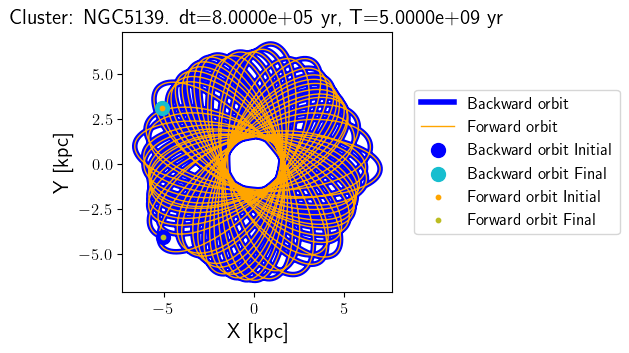

In [9]:
plotdata0={"x":backwardorbit[0],"y":backwardorbit[1]}
plotdata1={"x":forwardorbit[0],"y":forwardorbit[1]}
pltobj0={"label":"Backward orbit","color":"blue"}
pltobj1={"label":"Forward orbit","color":"orange"}
title="Cluster: {}. dt={:.4e} yr, T={:.4e} yr".format(targetGC,timestep,integrationtime)
axisconfig={'xlabel':"X [kpc]",'ylabel':"Y [kpc]",'aspect':'equal','title':title}
fig,axis=bsitt.plot_orbits([plotdata0,plotdata1],[pltobj0,pltobj1],axisconfig)

In [10]:
x_back = np.flip(backwardorbit[0])
x_forward = forwardorbit[0]
y_back = np.flip(backwardorbit[1])
y_forward = forwardorbit[1]
z_back = np.flip(backwardorbit[2])
z_forward = forwardorbit[2]
timearray = np.linspace(-integrationtime,0,len(x_back))* u.yr
timearray = timearray.to(unitT)
xmin = min(x_back)
xmax = max(x_back)
drift = np.sqrt((x_back-x_forward)**2 + (y_back-y_forward)**2 + (z_back-z_forward)**2)


(1e-14, 20.0)

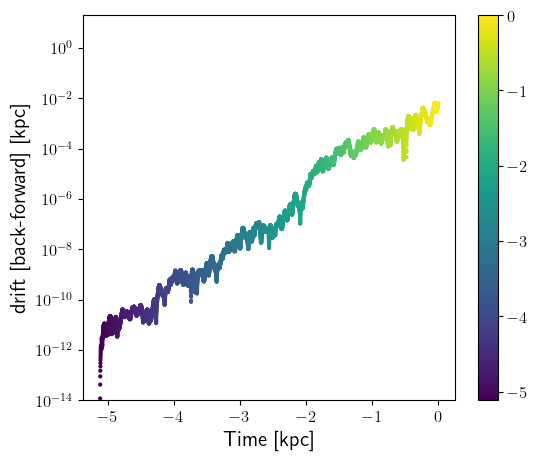

In [11]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(timearray,drift,c=timearray,cmap='viridis',s=4)
cbar = plt.colorbar(im, ax=axis)
# axis.plot([xmin,xmax],[xmin,xmax],color='black',linestyle='-',zorder=0)
axis.set_xlabel("Time [kpc]")
axis.set_ylabel("drift [back-forward] [kpc]")
axis.set_yscale('log')
axis.set_ylim(1e-14,2e1)

In [12]:
abar_x_forward = forwardaccel[1][0]
abar_x_backward = np.flip(backcaccel[1][0])
abar_y_forward = forwardaccel[1][1]
abar_y_backward = np.flip(backcaccel[1][1])
abar_z_forward = forwardaccel[1][2]
abar_z_backward = np.flip(backcaccel[1][2])
adrift = np.sqrt((abar_x_forward-abar_x_backward)**2 + (abar_y_forward-abar_y_backward)**2 + (abar_z_forward-abar_z_backward)**2)

(1e-14, 100.0)

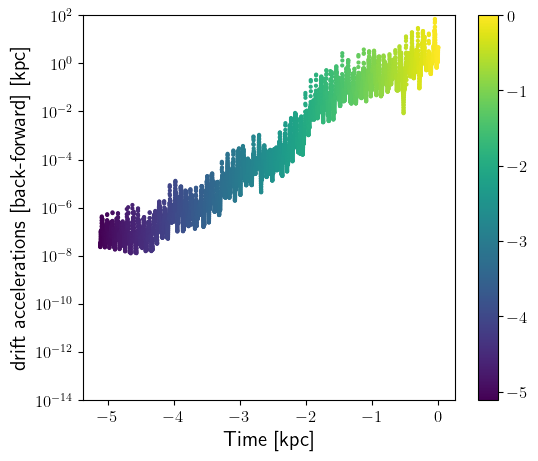

In [13]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(timearray,adrift,c=timearray,cmap='viridis',s=4)
cbar = plt.colorbar(im, ax=axis)
axis.set_yscale('log')
axis.set_xlabel("Time [kpc]")
axis.set_ylabel("drift accelerations [back-forward] [kpc]")
axis.set_ylim(1e-14,1e2)

In [148]:
thetaforward=forwardbartheta
thetaback=np.flip(backbartheta)
dtheta = np.sqrt((thetaforward-thetaback)**2)

Text(0, 0.5, 'Difference in bar angle [rad]')

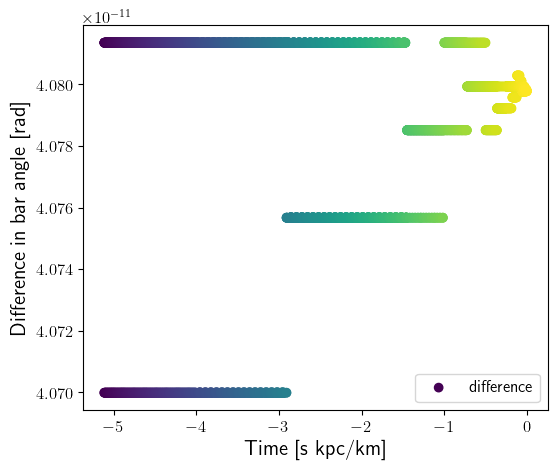

In [149]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
axis.scatter(timearray,dtheta,label="difference",c=timearray)
axis.legend()
axis.set_xlabel("Time [s kpc/km]")
axis.set_ylabel("Difference in bar angle [rad]")

# Magnitude of the accelerations

In [15]:
abar_backward = np.sqrt(abar_x_backward**2 + abar_y_backward**2 + abar_z_backward**2)
abar_forward = np.sqrt(abar_x_forward**2 + abar_y_forward**2 + abar_z_forward**2)
aSG_backward = np.sqrt(backcaccel[0][0]**2 + backcaccel[0][1]**2 + backcaccel[0][2]**2)
aSG_forward = np.sqrt(forwardaccel[0][0]**2 + forwardaccel[0][1]**2 + forwardaccel[0][2]**2)
aSG_backward = np.flip(aSG_backward)

Text(0, 0.5, 'Acceleration [km$^2$/ kpc s$^2$]')

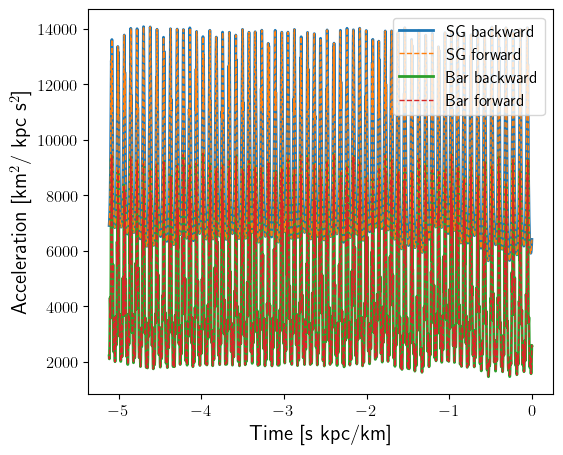

In [18]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
axis.plot(timearray,aSG_backward,label="SG backward",zorder=0,linewidth=2)
axis.plot(timearray,aSG_forward,label="SG forward",zorder=1,linestyle='--',linewidth=1)
axis.plot(timearray,abar_backward,label="Bar backward",zorder=0,linewidth=2)
axis.plot(timearray,abar_forward,label="Bar forward",zorder=1,linestyle='--',linewidth=1)
axis.legend()   
axis.set_xlabel("Time [s kpc/km]")
axis.set_ylabel("Acceleration [km$^2$/ kpc s$^2$]")

## Error found
I think the problem is the leapfrog integration scheme is introducing too much numerical error when the bar is included. Time steps of 1e6 years happened to be at the sweet spot of good enough integration to resolve the orbit, and also not many steps taken. It looks like the numerical error for the bar scales more with the number of steps. So smaller step size is actually worse. 

In [38]:
integrationtime = 5e9
drift_bar=[]
drift_SG=[]
drift_r=[]
drift_theta=[]
timearrays=[]
plotdata0s=[]
plotdata1s=[]

stepsizes = [1e4,1e5,5e5,8e5,1e6]
for i in range(len(stepsizes)):
    timestep=stepsizes[i]
    backwardorbit, forwardorbit, backcaccel, forwardaccel, backbartheta, forwardbartheta, backtimestamps, forwardtimestamps\
        =backward_and_forward_orbit(integrationtime,timestep,Galaxy,initialkinematics,bar)
    
    x_back = np.flip(backwardorbit[0])
    x_forward = forwardorbit[0]
    y_back = np.flip(backwardorbit[1])
    y_forward = forwardorbit[1]
    z_back = np.flip(backwardorbit[2])
    z_forward = forwardorbit[2]
    abar_x_backward = np.flip(backcaccel[1][0])
    abar_x_forward = forwardaccel[1][0]
    abar_y_backward = np.flip(backcaccel[1][1])
    abar_y_forward = forwardaccel[1][1]
    abar_z_backward = np.flip(backcaccel[1][2])
    abar_z_forward = forwardaccel[1][2]
    aSG_x_backward = np.flip(backcaccel[0][0])
    aSG_x_forward = forwardaccel[0][0]
    aSG_y_backward = np.flip(backcaccel[0][1])
    aSG_y_forward = forwardaccel[0][1]
    aSG_z_backward = np.flip(backcaccel[0][2])
    aSG_z_forward = forwardaccel[0][2]





    timearray = np.linspace(-integrationtime,0,len(x_back))* u.yr
    timearray = timearray.to(unitT)
    r_drift = np.sqrt((x_back-x_forward)**2 + (y_back-y_forward)**2 + (z_back-z_forward)**2)
    abar_drift = np.sqrt((abar_x_backward-abar_x_forward)**2 + (abar_y_backward-abar_y_forward)**2 + (abar_z_backward-abar_z_forward)**2)
    aSG_drift = np.sqrt((aSG_x_backward-aSG_x_forward)**2 + (aSG_y_backward-aSG_y_forward)**2 + (aSG_z_backward-aSG_z_forward)**2)  

    thetaforward=forwardbartheta
    thetaback=np.flip(backbartheta)
    dtheta = np.sqrt((thetaforward-thetaback)**2)

    # store the outputs
    drift_r.append(r_drift)
    drift_bar.append(abar_drift)
    drift_SG.append(aSG_drift)
    drift_theta.append(dtheta)
    timearrays.append(timearray)

    plotdata0s.append({"x":backwardorbit[0],"y":backwardorbit[1]})
    plotdata1s.append({"x":forwardorbit[0],"y":forwardorbit[1]})



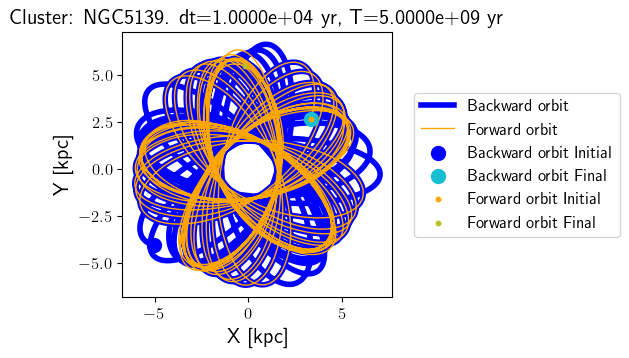

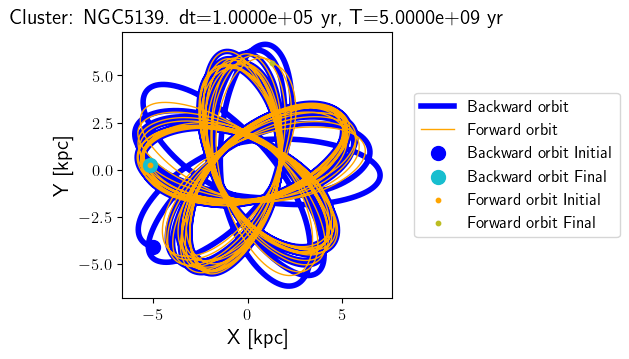

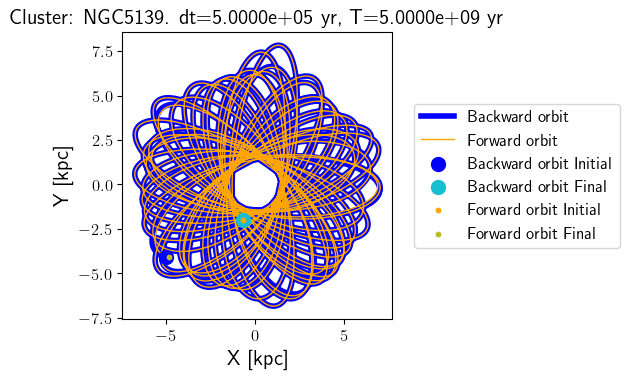

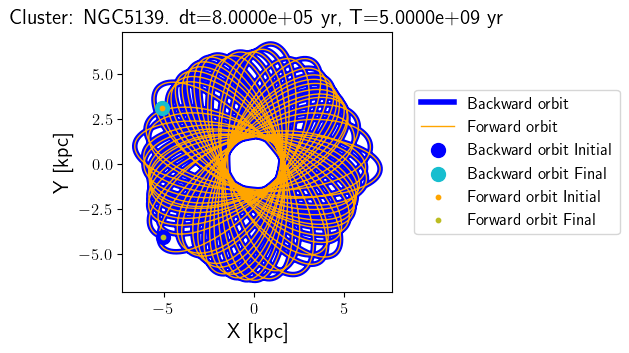

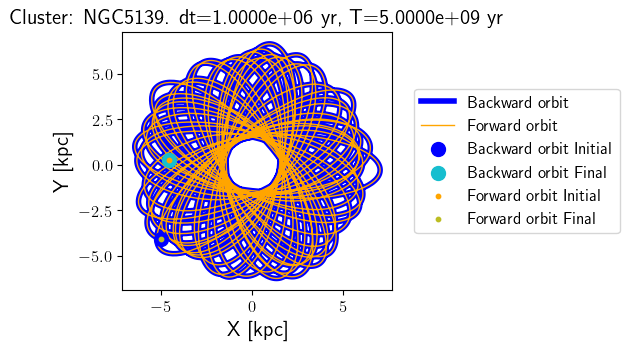

In [40]:
for i in range(len(stepsizes)):
    title="Cluster: {}. dt={:.4e} yr, T={:.4e} yr".format(targetGC,stepsizes[i],integrationtime)
    axisconfig={'xlabel':"X [kpc]",'ylabel':"Y [kpc]",'aspect':'equal','title':title}
    fig,axis=bsitt.plot_orbits([plotdata0s[i],plotdata1s[i]],[pltobj0,pltobj1],axisconfig)

# Numerical error 

Text(0.5, 0, 'Time [s kpc/km]')

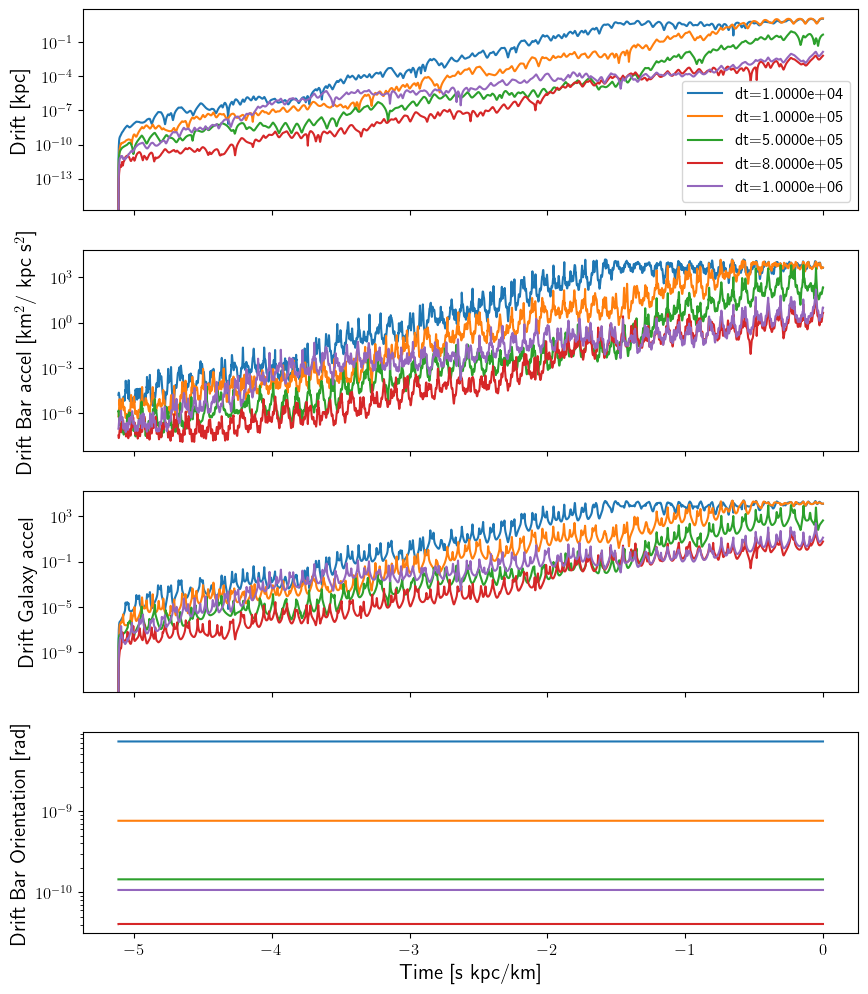

In [34]:
fig,axis=plt.subplots(4,1,figsize=(10,12),sharex=True)
for i in range(len(stepsizes)):
    axis[0].plot(timearrays[i],drift_r[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[1].plot(timearrays[i],drift_bar[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[2].plot(timearrays[i],drift_SG[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[3].plot(timearrays[i],drift_theta[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[0].set_yscale('log')
    axis[1].set_yscale('log')
    axis[2].set_yscale('log')
    axis[3].set_yscale('log')
    axis[0].set_ylabel("Drift [kpc]")
    axis[1].set_ylabel("Drift Bar accel [km$^2$/ kpc s$^2$]")
    axis[2].set_ylabel("Drift Galaxy accel ")
    axis[3].set_ylabel("Drift Bar Orientation [rad]")
axis[0].legend()
axis[3].set_xlabel("Time [s kpc/km]")

Text(0.5, 0, 'Number of integration steps')

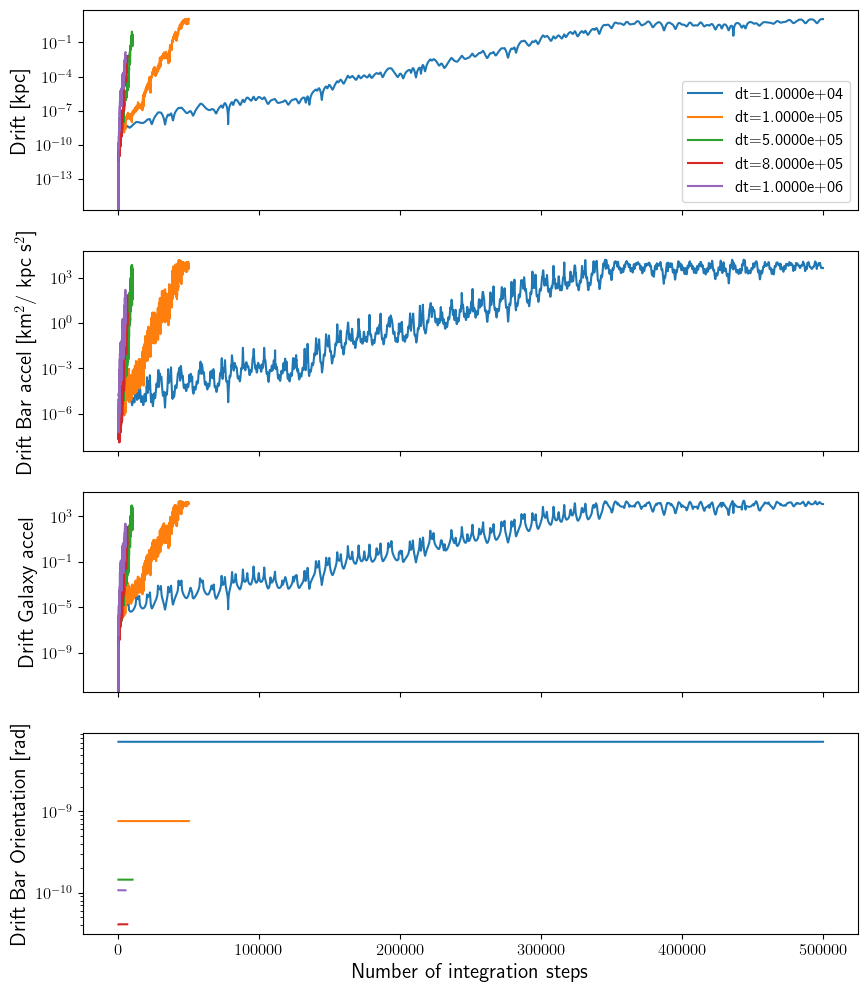

In [37]:
fig,axis=plt.subplots(4,1,figsize=(10,12),sharex=True)
for i in range(len(stepsizes)):
    stepnumber = np.arange(0,len(drift_r[i]))
    axis[0].plot(stepnumber,drift_r[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[1].plot(stepnumber,drift_bar[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[2].plot(stepnumber,drift_SG[i],label="dt={:.4e}".format(stepsizes[i]))
    axis[3].plot(stepnumber,drift_theta[i],label="dt={:.4e}".format(stepsizes[i]))

for ax in axis:
    ax.set_yscale('log')

axis[0].set_ylabel("Drift [kpc]")
axis[1].set_ylabel("Drift Bar accel [km$^2$/ kpc s$^2$]")
axis[2].set_ylabel("Drift Galaxy accel ")
axis[3].set_ylabel("Drift Bar Orientation [rad]")
axis[0].legend()
axis[3].set_xlabel("Number of integration steps")


hmmmm. The bar drift acceleration does indeed start pretty high